In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import Dense, BatchNormalization, Activation, Dropout
from tensorflow import keras
from numba import cuda

from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet_v2 import ResNet50V2 
from tensorflow.keras.applications.resnet_v2 import ResNet101V2

import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

import gc

print("Loading Libraries Done")

Loading Libraries Done


### 2) Data loading

In [2]:

main_folder = "Iceberg_Dataset"
RANDOM_SEED = 6

categories = os.listdir(main_folder)
try:
    categories.remove(".DS_Store")
except:
    pass
print(categories, len(categories))



['iceberg', 'noiceberg'] 2


# Data augmentation

In [3]:
TOTAL_CATEGORIES = len(categories)
IMAGE_SIZE = (75,75,3)

def load_images_labels(categories):
    img_lst=[]
    labels=[]
    for index, category in enumerate(categories):
        print(index, category)
        for image_name in tqdm(os.listdir(main_folder+"/"+category)):
            file_ext = image_name.split(".")[-1]
            if (file_ext.lower() == "jpg") or (file_ext.lower() == "jpeg") or (file_ext.lower() == "png"):
              try:
                    imgname = main_folder+"/"+category+"/"+image_name
                    imgname = imgname.replace("//", "/")

                    img = cv2.imread(imgname)
           
                    img = cv2.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                    img_rotated_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
                    img_rotated_180 = cv2.rotate(img, cv2.ROTATE_180)
                    img_rotated_270 = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
                    img_flip_ver = cv2.flip(img, 0)
                    img_flip_hor = cv2.flip(img, 1)

                    img_array = Image.fromarray(img, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_90, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_180, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_rotated_270, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_ver, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

                    img_array = Image.fromarray(img_flip_hor, 'RGB')
                    img_lst.append(np.array(img_array))
                    labels.append(index)

              except Exception as e:
                print(e)
                print(imgname)
                print(img)
                

    return img_lst, labels

images, labels = load_images_labels(categories)
print()
print("Total Images Loaded:", len(images))

0 iceberg


100%|██████████| 753/753 [00:00<00:00, 1949.34it/s]


1 noiceberg


100%|██████████| 851/851 [00:00<00:00, 2097.14it/s]


Total Images Loaded: 9624


In [4]:
images = np.array(images)
labels = np.array(labels)

In [5]:
np.random.seed(RANDOM_SEED)

n = np.arange(images.shape[0])
np.random.shuffle(n)

images = images[n]
labels = labels[n]

- Step 2 - Data normalization

In [6]:
images = images.astype(np.float32)
labels = labels.astype(np.int8)
images /= 255
print("Images shape after normalization = ",images.shape)

Images shape after normalization =  (9624, 75, 75, 3)


- Split dataset for training and testing

In [7]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = RANDOM_SEED)


print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)
print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (7699, 75, 75, 3)
y_train shape =  (7699,)

x_test shape =  (1925, 75, 75, 3)
y_test shape =  (1925,)


In [8]:
del(images)
del(labels)

In [9]:
EPOCHS = 100
BATCH_SIZE = 32

# RESNET 50

In [10]:
resnet_50 = ResNet50(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [11]:
#do not train the pre-trained layers
for layer in resnet_50.layers:
    layer.trainable = False

In [12]:
x = Flatten()(resnet_50.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_model = Model(inputs=resnet_50.input, outputs=prediction)
# view the structure of the model
resnet_50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 81, 81, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 38, 38, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 38, 38, 64)   256         ['conv1_conv[0][0]']             
                                                                                              

In [13]:
resnet_50_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [14]:
earlyStopping = EarlyStopping(monitor='val_acc', patience=20, verbose=0, mode='max')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

resnet_50_history = resnet_50_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/100
240/240 [==============================] - 15s 24ms/step - loss: 0.6473 - acc: 0.6852 - val_loss: 2.2054 - val_acc: 0.5432 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 5s 19ms/step - loss: 0.5070 - acc: 0.7415 - val_loss: 1.2604 - val_acc: 0.4573 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 4s 18ms/step - loss: 0.4676 - acc: 0.7597 - val_loss: 17.8529 - val_acc: 0.5432 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 4s 19ms/step - loss: 0.4515 - acc: 0.7719 - val_loss: 4.1741 - val_acc: 0.5432 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 4s 19ms/step - loss: 0.4436 - acc: 0.7772 - val_loss: 3.0509 - val_acc: 0.5432 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 5s 19ms/step - loss: 0.4293 - acc: 0.7883 - val_loss: 7.5651 - val_acc: 0.5432 - lr: 0.0010
Epoch 7/100
240/240 [==============================] - 4s 19ms/step - loss: 0.4249 - acc: 0.7918 - val_loss: 4.5340 

In [15]:
resnet_50_loss,resnet_50_acc = resnet_50_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50 Loss:", resnet_50_loss)
print("Resnet_50 Accuracy:", resnet_50_acc*100, "%")

61/61 [==============================] - 1s 14ms/step - loss: 0.3449 - acc: 0.8291
Resnet_50 Loss: 0.3449257016181946
Resnet_50 Accuracy: 82.90908932685852 %


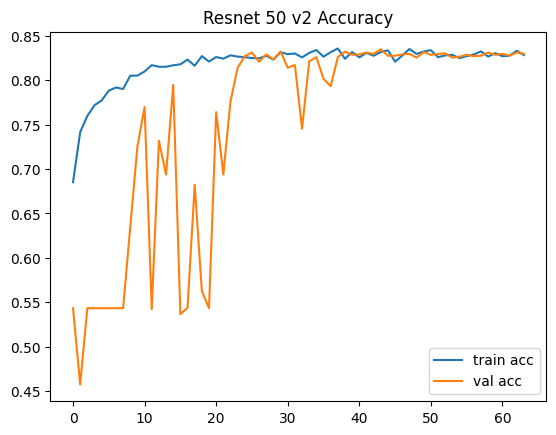

In [16]:
# accuracies
plt.plot(resnet_50_history.history['acc'], label='train acc')
plt.plot(resnet_50_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

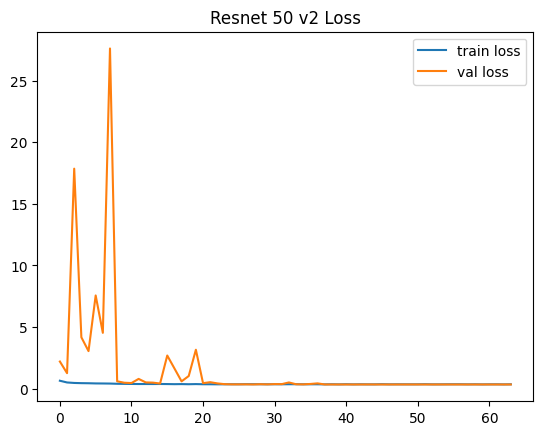

In [17]:
# loss
plt.plot(resnet_50_history.history['loss'], label='train loss')
plt.plot(resnet_50_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [18]:
#predict
y_pred=resnet_50_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

61/61 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       834
           1       0.86      0.83      0.85      1091

    accuracy                           0.83      1925
   macro avg       0.83      0.83      0.83      1925
weighted avg       0.83      0.83      0.83      1925



In [19]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

resnet_50_model.save("icebergdetection_resnet_50_model.h5", save_format="h5")

[[691 143]
 [186 905]]


# RESNET 50 v2

In [10]:
resnet_50_v2 = ResNet50V2(input_shape=IMAGE_SIZE , weights='imagenet', include_top=False)

In [11]:
#do not train the pre-trained layers
for layer in resnet_50_v2.layers:
    layer.trainable = False

In [12]:
x = Flatten()(resnet_50_v2.output)

# three hidden layers
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)
x = Dense(100, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)


#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(TOTAL_CATEGORIES, activation='softmax')(x)
resnet_50_v2_model = Model(inputs=resnet_50_v2.input, outputs=prediction)
# view the structure of the model
resnet_50_v2_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 81, 81, 3)    0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 38, 38, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 40, 40, 64)   0           ['conv1_conv[0][0]']             
                                                                                              

In [13]:
resnet_50_v2_model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['acc'])

In [14]:

earlyStopping = EarlyStopping(monitor='val_acc', patience=20, verbose=0, mode='max')
mcp_save = ModelCheckpoint('mdl_wts.hdf5', save_best_only=True, monitor='val_acc', mode='max', restore_best_weights=True)
reduce_lr_loss = ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='max')

resnet_50_v2_history = resnet_50_v2_model.fit(x_train, y_train, validation_data=(x_test, y_test), steps_per_epoch = x_train.shape[0]//BATCH_SIZE, epochs=EPOCHS, callbacks=[earlyStopping, mcp_save, reduce_lr_loss], batch_size=BATCH_SIZE, validation_steps = y_test.shape[0]//BATCH_SIZE, shuffle=True)

Epoch 1/100
240/240 [==============================] - 9s 23ms/step - loss: 0.5684 - acc: 0.7298 - val_loss: 0.4014 - val_acc: 0.8021 - lr: 0.0010
Epoch 2/100
240/240 [==============================] - 5s 20ms/step - loss: 0.4076 - acc: 0.8092 - val_loss: 0.3676 - val_acc: 0.8276 - lr: 0.0010
Epoch 3/100
240/240 [==============================] - 4s 18ms/step - loss: 0.3445 - acc: 0.8391 - val_loss: 0.3714 - val_acc: 0.8245 - lr: 0.0010
Epoch 4/100
240/240 [==============================] - 5s 19ms/step - loss: 0.3181 - acc: 0.8521 - val_loss: 0.3477 - val_acc: 0.8302 - lr: 0.0010
Epoch 5/100
240/240 [==============================] - 4s 18ms/step - loss: 0.2876 - acc: 0.8724 - val_loss: 0.3484 - val_acc: 0.8276 - lr: 0.0010
Epoch 6/100
240/240 [==============================] - 4s 18ms/step - loss: 0.2649 - acc: 0.8856 - val_loss: 0.3880 - val_acc: 0.8224 - lr: 0.0010
Epoch 7/100
240/240 [==============================] - 4s 18ms/step - loss: 0.2514 - acc: 0.8910 - val_loss: 0.3824 - 

In [15]:
resnet_50_v2_loss,resnet_50_v2_acc = resnet_50_v2_model.evaluate(x_test,y_test,batch_size=32)
print("Resnet_50_V2 Loss:", resnet_50_v2_loss)
print("Resnet_50_V2 Accuracy:", resnet_50_v2_acc*100, "%")

61/61 [==============================] - 1s 13ms/step - loss: 0.6451 - acc: 0.8223
Resnet_50_V2 Loss: 0.6451164484024048
Resnet_50_V2 Accuracy: 82.23376870155334 %


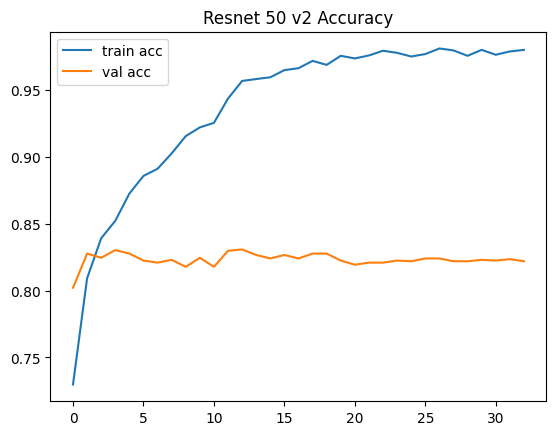

In [16]:
# accuracies
plt.plot(resnet_50_v2_history.history['acc'], label='train acc')
plt.plot(resnet_50_v2_history.history['val_acc'], label='val acc')
plt.title("Resnet 50 v2 Accuracy")
plt.legend()
plt.show()

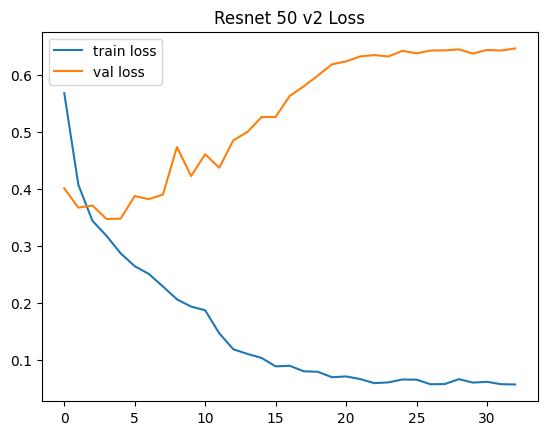

In [17]:
# loss
plt.plot(resnet_50_v2_history.history['loss'], label='train loss')
plt.plot(resnet_50_v2_history.history['val_loss'], label='val loss')
plt.title("Resnet 50 v2 Loss")
plt.legend()
plt.show()

In [1]:
#predict
y_pred=resnet_50_v2_model.predict(x_test)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,y_test))

NameError: name 'resnet_50_v2_model' is not defined

In [19]:
print(confusion_matrix(y_pred,y_test))#get confusion matrix

resnet_50_v2_model.save("icebergdetection_resnet_50v2_model.h5", save_format="h5")

[[724 189]
 [153 859]]
